In [20]:
import sys
sys.path.insert(0, '../../Utilities/')

#import tensorflow as tf
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import scipy.io

from scipy.interpolate import griddata
from scipy.stats import uniform
#import time

plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rc('text', usetex=True)

In [24]:
n = 3     # nr of pars
N = 100   # sample size
Nmax = N

# Data
a = np.random.uniform(low=0.,high=1.,size=(N,n)) 

# Synthetic truth
astar = np.random.uniform(low=0.,high=1.,size=(3))

# Parameters
k=-1. # decay reaction

#Functions
def u0(x,a):
    a1,a2,a3 = a #1 + a2 # for continuity i should maybe add baseline to a1, if i really want to have continuity.
    return a1+a2

def ub(x,t,a):
    a1,a2,a3 = a
    return a1 + a2*(1.+a3*np.sin(2.*np.pi*t)) # I do not want ub to be negative, for physical meaning of the variables

def L0(x):
    return np.sqrt(2.)

def Lb(x,t):
    lip = np.sqrt(2.+2.*np.sin(2.*np.pi*t)**2+2.*np.amax((0.,np.sin(2.*np.pi*t)))) 
    return  lip

 


# Construction of the Wasserstein ambiguity set

We employ Lemma 4.1 working in relative terms. 

Let us assume that for a given confidence level $1-\beta$, the radius of the AS with $N=10$ is given by $\epsilon_N=0.1$. Then by employing Lemma 4.1 with $n=3$ and $p=1$, the ratio between radiuses with given confidence level and different sample size is given by $\epsilon_{N'} / \epsilon_{N} = (N/N')^{1/3}$.

In [26]:
Nref = [10,10]
epsilonNref = [.2,.1]

def epsilonNprime(Nprime,epsilonNref,Nref):
    return epsilonNref*(Nref/Nprime)**(1./3)

These epsilons are the threshold values for the WAS with given (unknown) confidence level and given (known) sample size for the parameters.

Now that we have the WAS for the parameters, we can use the Lipschitz constant to scale the input conditions for the W1 evolution equation. The ambiguity ball with that space-time variable radius will be anchored on a nominal/empirical distribution whose space time evolution is governed by the CDF equation.

In [29]:
amin = 0.
amax = 1.

U0min = amin
U0max = amax*2.

Ubmin = 0. 

def Ubmax(x,t):
    if (((t-np.floor(t))>=0.) and ((t-np.floor(t))<=.5)):
        Ubmax = 2.+np.sin(2.*np.pi*t)
    else:
        Ubmax = 2.
    return Ubmax


In [30]:
def W10sol(x,N,epsilonNref,Nref):
    W10 = L0(x)*epsilonNprime(N,epsilonNref,Nref)
    W10max = U0max-U0min
    if W10>W10max:
        W10 = W10max
    return W10

def W1bsol(x,t,N,epsilonNref,Nref):
    W1b = Lb(x,t)*epsilonNprime(N,epsilonNref,Nref)
    W1bmax = Deltabmax(x,t)*1.
    if W1b>=W1bmax:
        W1b = W1bmax
    return W1b

def W1sol(x,t,N,epsilonNref,Nref): 
    
    if (x>=t): # IC region
        sol = W10sol(x-t,N,epsilonNref,Nref)*np.exp(k*t) 
    else: # BC region
        sol = W1bsol(0.,t-x,N,epsilonNref,Nref)*np.exp(k*x)
    return sol

In [31]:
Nx = 100
Nt = 200
Nvalues = [25,100]
NNs = np.shape(Nvalues)[0]
Nbetas = np.shape(Nref)[0]

xend = 2.
tend = 2.

X = np.linspace(0.,xend,Nx)
T = np.linspace(0.,tend,Nt)
Xmg, Tmg = np.meshgrid(X, T)
W1_WAS = np.zeros((NNs,Nbetas,Nx,Nt))

W10_WAS = np.zeros((NNs,Nbetas))
W1b_WAS = np.zeros((NNs,Nbetas,Nt))


def Delta0max(x):
    return 2.

def Deltabmax(x,t):
    if ((t-np.floor(t))>=0.) & ((t-np.floor(t))<0.5):
        deltab = 2.+np.sin(2.*np.pi*t)
    else:
        deltab = 2.
    
    return deltab # conservative range

for ib in range(0,Nbetas):
    for inn in range(0,NNs):
        
        for ix in range(0,Nx):
            W10_WAS[inn,ib] = W10sol(X[ix],Nvalues[inn],epsilonNref[ib],Nref[ib]) #L0(X[ix])*epsilonNprime(Nvalues[inn],epsilonNref[ib],Nref[ib])
            for it in range(0,Nt):
                W1_WAS[inn,ib,ix,it] = W1sol(X[ix],T[it],Nvalues[inn],epsilonNref[ib],Nref[ib])
                W1b_WAS[inn,ib,it] = W1bsol(X[ix],T[it],Nvalues[inn],epsilonNref[ib],Nref[ib]) #Lb(X[ix],T[it])*epsilonNprime(Nvalues[inn],epsilonNref[ib],Nref[ib])

/Users/francesca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


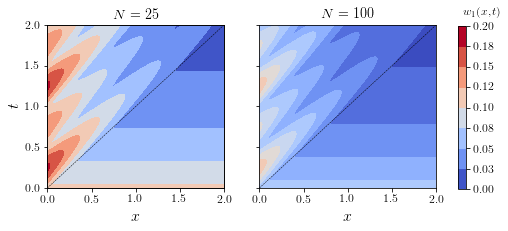

In [36]:
fig,axes = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(6,3))
ax2_01 = axes[0].twinx()
ax2_01.set_yticks([])
axes[0].set_ylabel(r"$t$",fontsize=16)
axes[0].set_xlabel(r"$x$",fontsize=16)
axes[1].set_xlabel(r"$x$",fontsize=16)

b0=np.str((Nvalues[0])) # '.2f'
b1=np.str((Nvalues[1])) # '.2f'
axes[0].set_title(r'$N = \; $' + b0)
axes[1].set_title(r'$N = \; $' + b1)

maxvalue0 = np.amax(W1_WAS[:,0,:,:])
minvalue0 = np.amin(W1_WAS[:,0,:,:])
maxvalue1 = np.amax(W1_WAS[:,1,:,:])
minvalue1 = np.amin(W1_WAS[:,1,:,:])

ib = 1
for inn in range(0,NNs):
        
        if inn==0:
            pcf00 = axes[inn].contourf(Xmg,Tmg,np.transpose(W1_WAS[inn,ib,:,:]),vmin=minvalue1,vmax=maxvalue1,cmap='coolwarm')
            pcf = axes[inn].contourf(Xmg,Tmg,np.transpose(W1_WAS[inn,ib,:,:]),vmin=minvalue1,vmax=maxvalue1,cmap='coolwarm')
        
        
        pcf = axes[inn].contourf(Xmg,Tmg,np.transpose(W1_WAS[inn,ib,:,:]),vmin=minvalue1,vmax=maxvalue1,cmap='coolwarm')
        
        axes[inn].plot(X,X,c='k',linestyle='dashed',linewidth=.5)
        axes[inn].set_xlim(left=0., right=xend)
        axes[inn].set_ylim(top=tend, bottom=0.)
        
axes[1].text(2.3, 2.1, r'$w_1(x,t)$', fontsize=12)

fig.subplots_adjust( left=0., 
                     wspace=0.2)


cb_ax = fig.add_axes([.95, 0.12, 0.02, 0.755])
cbar = fig.colorbar(pcf00, cax=cb_ax,format='%.2f')
cbar.ax.locator_params(nbins=10)

plt.savefig('Figure6.pdf', dpi=800,
        frameon=None, bbox_inches='tight')

# Ambiguity band

For the same values of beta and N, now we compute the wider Ambiguity band with the geometrical procedure outlined in Lemma 4.6. The values taken as a reference are the rho values for the inputs (at initial time and along the boundaries), which define the envelopes pointwise. 

In [43]:
# Functions for the construction of the ambiguity band

def tcconstruction(a,Umin,Umax,Nval): # size of the considered sample
    t = np.zeros((Nval+2)) # n is i in the text
    t[0] = Umin
    t[Nval+1] = Umax
    for inn in range(0,n):
        t[1:Nval+1] = (np.sort(a[0:Nval]))
    c = np.zeros((Nval+2))
    c[:] = 1./(Nval)
    c[0] = 0. # convention
    return t,c

def bconstruction(t):
    Nval = np.shape(t)[0]-2
    b = np.zeros((Nval+2,Nval+2))

    for i in range(0,Nval+1):
        for j in range(0,Nval+1):
            if j <= i:
                for k in range(j,i+1):
                    b[i,j] = b[i,j] + (t[k]-t[j])*c[k]

    b[Nval,0] = 0.
    for i in range(0,Nval):
        b[Nval,0] = b[Nval,0] + (t[i]-t[0])*c[i]
        
    return b

def indexing(b,t,rho):
    Nval = np.shape(t)[0]-2
    
    js = [0]
    iss = [0]

    js = np.append(js,0) # this is j_1
    ivalue = np.amin(np.where(b[1:Nval+1,0]>=rho))+1
    iss = np.append(iss,ivalue) # this is i_1

    for k in range(1,Nval+1):
        
        jvalue = np.amax(np.where(b[iss[k],js[k]:iss[k]+1]>=rho))+1+js[k] 
        js = np.append(js,jvalue) # this is j_k+1
        
        if (b[Nval,jvalue]<=rho) and b[Nval,js[k]]>rho: 
            kmax = k
            break
        
        ivalue = np.amin(np.where(b[iss[k]+1:Nval+1,jvalue]>=rho))+iss[k]+1 # this is i_k+1
        iss = np.append(iss,ivalue)
        
    iss = np.append(iss,Nval + 1) 

    deltay = np.zeros((Nval+1,kmax+1))
    deltat = np.zeros((Nval+1,kmax+1))
    y = np.zeros((Nval+2))
    tau = np.zeros((Nval+2))

    for k in range(1,kmax+1): # inclusive range
        for l in range(js[k],js[k+1]):
            
            deltay[l,k] = (rho-b[iss[k]-1,l])/(t[iss[k]]-t[l])
        for l in range(iss[k],iss[k+1]-1+1):
            deltat[l,k] = (rho-b[l,js[k+1]])/(np.sum(c[js[k+1]:l+1]))

    for l in range(0,Nval+2):
        for k in range(1,kmax+1):
            if (l>=js[k] and l<=js[k+1]-1):
                y[l] = np.sum(c[1:iss[k]]) + deltay[l,k]
            if (l>=iss[k] and l <= iss[k+1]-1):
                tau[l] = t[js[k+1]]-deltat[l,k]
                
    return js,iss,y,tau,kmax

def Fup(U,t,b,js,iss,y,tau,kmax,Umin,Umax): 
    Nval = np.shape(t)[0]-2
    z = np.zeros(Nval+1)
    Fval = 0.
    Ftype = -1
    Fell = -2
    for ell in range(0,Nval+1):
        z[ell] = np.sum(c[0:ell+1])
    if U<Umin:
        Fval = 0.
        Ftype = 0
    elif U>=tau[Nval]:
        Fval = 1.
        Ftype = 1
        
    else:
        for ell in range(0,Nval+1):
            for k in range(1,kmax+1):
                if ell>=js[k] and ell<=js[k+1]-2:
                    if (U>=t[ell] and U<t[ell+1]):
                        Fval = z[ell]+(y[ell]-z[ell])*(t[iss[k]]-t[ell])/(t[iss[k]]-U)
                        Ftype = 2
                        Fell = ell
                        
                if ell == js[k+1]-1:
                    if (U>=t[js[k+1]-1] and U<tau[iss[k]]):
                        Fval = z[ell]+(y[ell]-z[ell])*(t[iss[k]]-t[ell])/(t[iss[k]]-U)
                        Ftype = 3
                        Fell = ell
                        
                if ell>=iss[k] and ell<=iss[k+1]-2:
                    if (U>=tau[ell] and U<tau[ell+1]):
                        Fval = z[js[k+1]-1]+(z[ell]-z[js[k+1]-1])*(t[ell+1]-tau[ell])/(t[ell+1]-U)
                        Ftype = 4
                        Fell = ell
                        
                if ell == iss[k+1]-1:
                    if (U>=tau[iss[k+1]-1] and U<t[js[k+1]]):
                        Fval = z[js[k+1]-1]+(z[ell]-z[js[k+1]-1])*(t[ell+1]-tau[ell])/(t[ell+1]-U)
                        Ftype = 5
                        Fell = ell
                        
    return Fval, Ftype, Fell


def rc_ecdf(U,t):
    Nval = np.shape(t)[0]-2
    
    for i in range(1,Nval+1):
        if U>=t[i] and U<t[i+1]:
            value = (i)/(Nval)
        elif U<t[1]:
            value = 0.
        elif U>t[Nval]:
            value = 1.
    return value

def rc_ecdf2(U,t):
    Nval = np.shape(t)[0]-2
    
    for i in range(1,Nval+1):
        if U>=t[i] and U<t[i+1]:
            value = (i-1)/(Nval) # was i-1
        elif U<t[1]:
            value = 0.
        elif U>t[Nval]:
            value = 1.
    return value

def ecdf(t):
    Nval = np.shape(t)[0]-2
    tx = t[1:Nval+1]
    ecdf = tx*0.
    for i in range(0,Nval):
        ecdf[i] = (i+1)/(Nval)
    return tx,ecdf


def treflF(t,Umin,Umax):
    
    Nval = np.shape(t)[0]-2
    
    trefl = t*0.
    
    trefl[1:Nval+1] = Umin+Umax-t[1:Nval+1]
    trefl[1:Nval+1] = np.flip(trefl[1:Nval+1])
    trefl[0] = Umin
    trefl[Nval+1] = Umax
    
    return trefl

In [44]:
def envelopeu0(x,U,Nval,rho,amin,amax,a): 
    
    Umin = amin
    Umax = 2.*amax
    
    u0sample = a[:,0]+a[:,1]
    
    t,c = tcconstruction(u0sample,Umin,Umax,Nval) 
    b = bconstruction(t)
    js,iss,y,tau,kmax = indexing(b,t,rho)

    
    upper = Fup(U,t,b,js,iss,y,tau,kmax,Umin,Umax)[0]
    
    tr = treflF(t,Umin,Umax)
    br = bconstruction(tr)
    jsr,issr,yr,taur,kmaxr = indexing(br,tr,rho)
    
    lower = 1. - Fup(Umin+Umax-U,tr,br,jsr,issr,yr,taur,kmaxr,Umin,Umax)[0]
    
    return U,lower,upper,u0sample


def envelopeub(time,U,Nval,rho,a): 
    
    Umin = 0.
    Umax = Ubmax(0.,time)
    
    ubsample = a[:,0] + a[:,1]*(a[:,2]*np.sin(2.*np.pi*time)+1.)
    
    t,c = tcconstruction(ubsample,Umin,Umax,Nval) 
    
    if (np.amax(t)>Umax):
        print('pb ',time)
    b = bconstruction(t)
    js,iss,y,tau,kmax = indexing(b,t,rho)
    
    upper = Fup(U,t,b,js,iss,y,tau,kmax,Umin,Umax)[0]
    
    tr = treflF(t,Umin,Umax)
    br = bconstruction(tr)
    jsr,issr,yr,taur,kmaxr = indexing(br,tr,rho)
    
    lower = 1. - Fup(Umin+Umax-U,tr,br,jsr,issr,yr,taur,kmaxr,Umin,Umax)[0]
    
    return U,lower,upper,ubsample

In [50]:
NU = 100

def rho0(x,N,epsilonNref,Nref):
     return L0(x)*epsilonNprime(N,epsilonNref,Nref)

def rhob(x,t,N,epsilonNref,Nref):
    return Lb(0.,t)*epsilonNprime(N,epsilonNref,Nref)  
    
NtE = 99 # It will have to be changed if  tend changes.

tstars = T 

tstar = tstars 
xstar = .5 

U0 = np.linspace(U0min,U0max,NU)

# since the boundary envelopes are periodic, I will just compute them for one period.

u0envelope = np.zeros((NNs,Nbetas,NU,3)) 
ubenvelope = np.zeros((NNs,Nbetas,NU,3,NtE)) 


W10_envelope = np.zeros((NNs,Nbetas))
W1b_envelope = np.zeros((NNs,Nbetas,NtE)) # this is at a specific tstar.

rhoIC = np.zeros((NNs,Nbetas))
rhoBC = np.zeros((NNs,Nbetas,NtE))

In [52]:
u0sample = a[:,0]+a[:,1]

ib=1

for nn in range(0,NNs):
            t,c = tcconstruction(u0sample,U0min,U0max,Nvalues[nn]) 

            print('nn,ib:',nn,ib)
            rhozero = rho0(xstar,Nvalues[nn],epsilonNref[ib],Nref[ib])
            
            rhoIC[nn,ib] = rhozero
            for iu in range(0,NU):
                uu,le,ue,u0sample = envelopeu0(.1,U0[iu],Nvalues[nn],rhozero,0.,1.,a)
                u0envelope[nn,ib,iu,:] = uu,le,ue
            
            W10_envelope[nn,ib] = np.trapz(u0envelope[nn,ib,:,2]-u0envelope[nn,ib,:,1],x=u0envelope[nn,ib,:,0]) 
            
            
for it in range(0,NtE):  
    ubsample = a[:,0] + a[:,1]*(1.+a[:,2]*np.sin(2.*np.pi*T[it]))
    
    Ub = np.linspace(0.,Ubmax(0.,T[it]),NU)
    for nn in range(0,NNs):
            t,c = tcconstruction(ubsample,Ubmin,Ubmax(0.,T[it]),Nvalues[nn])
            b = bconstruction(t)
            tr = treflF(t,Ubmin,Ubmax(0.,T[it]))
            br = bconstruction(tr)

            rhobi = rhob(xstar,T[it],Nvalues[nn],epsilonNref[ib],Nref[ib])
            print('nn,ib,it:',nn,ib,it,rhobi)
            print(b[Nvalues[nn],0],rhobi) # b[Nval,0] needs to be larger than rho
            rhoBC[nn,ib,it] = rhobi
            js,iss,y,tau,kmax = indexing(b,t,rhobi)
            jsr,issr,yr,taur,kmaxr = indexing(br,tr,rhobi)
                
            for iu in range(0,NU):
                uub,leb,ueb,ubsample = envelopeub(T[it],Ub[iu],Nvalues[nn],rhobi,a)
                ubenvelope[nn,ib,iu,:,it] = uub,leb,ueb
        
            W1b_envelope[nn,ib,it] = np.trapz(ubenvelope[nn,ib,:,2,it]-ubenvelope[nn,ib,:,1,it],x=ubenvelope[nn,ib,:,0,it]) 


nn,ib: 0 1
nn,ib: 1 1
nn,ib,it: 0 1 0 0.10420014619173827
0.9046939170931159 0.10420014619173827
nn,ib,it: 1 1 0 0.06564197879454708
0.9372001343695749 0.06564197879454708
nn,ib,it: 0 1 1 0.10763869816025337
0.9210537676698982 0.10763869816025337
nn,ib,it: 1 1 1 0.06780813079769189
0.9525072180997509 0.06780813079769189
nn,ib,it: 0 1 2 0.11134435584127592
0.9373484030833313 0.11134435584127592
nn,ib,it: 1 1 2 0.07014254885570437
0.9677532833040434 0.07014254885570437
nn,ib,it: 0 1 3 0.11527065289665668
0.9535128681368382 0.11527065289665668
nn,ib,it: 1 1 3 0.0726159610098116
0.9828775546943143 0.0726159610098116
nn,ib,it: 0 1 4 0.11937032726152688
0.9694827265310797 0.11937032726152688
nn,ib,it: 1 1 4 0.07519859402481878
0.997819742488293 0.07519859402481878
nn,ib,it: 0 1 5 0.12359646127582061
0.9851943177259455 0.12359646127582061
nn,ib,it: 1 1 5 0.07786089162696147
1.0125202827423356 0.07786089162696147
nn,ib,it: 0 1 6 0.127903309343411
1.0005850107101417 0.127903309343411
nn,ib,it: 

nn,ib,it: 1 1 54 0.06791054076311029
0.8728804293681525 0.06791054076311029
nn,ib,it: 0 1 55 0.10958074167014836
0.8203133386900009 0.10958074167014836
nn,ib,it: 1 1 55 0.06903154154665611
0.8580722067552998 0.06903154154665611
nn,ib,it: 0 1 56 0.11163744847854494
0.8050125118654783 0.11163744847854494
nn,ib,it: 1 1 56 0.07032718564733659
0.8434624275492121 0.07032718564733659
nn,ib,it: 0 1 57 0.11392457083587425
0.7901090443624389 0.11392457083587425
nn,ib,it: 1 1 57 0.07176798244817877
0.8292320613002764 0.07176798244817877
nn,ib,it: 0 1 58 0.11639323447752845
0.7756623457740883 0.11639323447752845
nn,ib,it: 1 1 58 0.0733231430917939
0.8154378344226524 0.0733231430917939
nn,ib,it: 0 1 59 0.1189940941892304
0.761730004878751 0.1189940941892304
nn,ib,it: 1 1 59 0.07496158204109231
0.8021347347510327 0.07496158204109231
nn,ib,it: 0 1 60 0.12167860963403972
0.7483675600741071 0.12167860963403972
nn,ib,it: 1 1 60 0.07665272079993388
0.7893757923429991 0.07665272079993388
nn,ib,it: 0 1 61 

/Users/francesca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


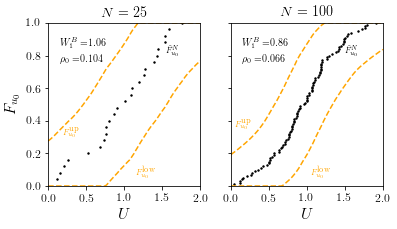

In [58]:
# figure for u_0

fig,axes = plt.subplots(1, NNs, sharex='all', sharey='all',figsize=(6,3))
axes[0].set_ylabel(r"$F_{u_0}$",fontsize=16)
axes[0].set_xlabel(r"$U$",fontsize=16)
axes[1].set_xlabel(r"$U$",fontsize=16)

b0=np.str(format(Nvalues[0])) # '.2f'
b1=np.str(format(Nvalues[1])) # '.2f'
axes[0].set_title(r'$N = \; $'+b0)
axes[1].set_title(r'$N = \; $'+b1)

ib = 1
for inn in range(0,NNs):
        ecdf = np.arange(1,Nvalues[inn]+1)/Nvalues[inn]
        axes[inn].scatter(np.sort(u0sample[0:Nvalues[inn]]),ecdf,s=2,c='k') # empirical cdf with the given nr of samples for the three pars
        axes[inn].plot(u0envelope[inn,ib,:,0],u0envelope[inn,ib,:,1],linestyle='dashed',c='orange')
        axes[inn].plot(u0envelope[inn,ib,:,0],u0envelope[inn,ib,:,2],linestyle='dashed',c='orange')
        axes[inn].set_xlim(left=0., right=2.)
        axes[inn].set_ylim(top=1., bottom=0.)
        s=np.str(format(W10_envelope[inn,ib],'.2f')) # '.2f'
        axes[inn].text(.15, .85, r'$W_1^{{B}}=$'+s, fontsize=10)
        r=np.str(format(rhoIC[inn,ib],'.3f')) # '.2f'
        axes[inn].text(.15, .75, r'$\rho_0=$'+r, fontsize=10)

axes[0].text(1.55,.8,r'$\widehat F^N_{u_0}$',fontsize=8)
axes[1].text(1.5,.8,r'$\widehat F^N_{u_0}$',fontsize=8)
axes[1].text(.05,.35,r'$ F^{\textnormal{up}}_{u_0}$',fontsize=8,color='orange')
axes[1].text(1.05,.05,r'$ F^{\textnormal{low}}_{u_0}$',fontsize=8,color='orange')

axes[0].text(.2,.3,r'$ F^{\textnormal{up}}_{u_0}$',fontsize=8,color='orange')
axes[0].text(1.15,.05,r'$ F^{\textnormal{low}}_{u_0}$',fontsize=8,color='orange')

plt.savefig('Figure4.pdf', dpi=800, bbox_inches='tight',
        frameon=None)

time  0.7537688442211056


/Users/francesca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/francesca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


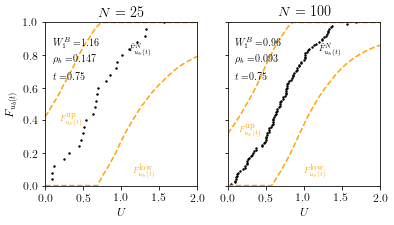

In [62]:
# figure for u_b at a given tstar

ib = 1

it = 75
ubsample = a[:,0] + a[:,1]*(1.+a[:,2]*np.sin(2.*np.pi*T[it]))
print('time ',tstars[it])
fig,axes = plt.subplots(1, NNs, sharex='all', sharey='all', figsize = (6,3))
axes[0].set_ylabel(r"$F_{u_b(t)}$")
axes[0].set_xlabel(r"$U$")
axes[1].set_xlabel(r"$U$")

b0=np.str(format(Nvalues[0])) # '.2f'
b1=np.str(format(Nvalues[1])) # '.2f'
axes[0].set_title(r'$N = \; $'+b0)
axes[1].set_title(r'$N = \; $'+b1)

for inn in range(0,NNs):

        ecdf = np.arange(1,Nvalues[inn]+1)/Nvalues[inn]
        axes[inn].scatter(np.sort(ubsample[0:Nvalues[inn]]),ecdf,s=2,c='k') # empirical cdf with the given nr of samples for the three pars
        axes[inn].plot(ubenvelope[inn,ib,:,0,it],ubenvelope[inn,ib,:,1,it],linestyle='dashed',c='orange')
        axes[inn].plot(ubenvelope[inn,ib,:,0,it],ubenvelope[inn,ib,:,2,it],linestyle='dashed',c='orange')
        axes[inn].set_xlim(left=0., right=Ubmax(0.,T[it]))
        axes[inn].set_ylim(top=1., bottom=0.)

        W1b_envelope[inn,ib,it] = np.trapz(-ubenvelope[inn,ib,:,1,it]+ubenvelope[inn,ib,:,2,it],x=ubenvelope[inn,ib,:,0,it])

        s=np.str(format(W1b_envelope[inn,ib,it],'.2f')) # '.2f'
        axes[inn].text(.1, .85, r'$W_1^{{B}}=$'+s, fontsize=10)
        r=np.str(format(rhoBC[inn,ib,it],'.3f')) # '.2f'
        axes[inn].text(.1, .75, r'$\rho_b=$'+r, fontsize=10)
        ts=np.str(format(T[it],'.2f')) # '.2f'
        axes[inn].text(.1, .65, r'$t=$'+ts, fontsize=10)

axes[0].text(1.1,.8,r'$\widehat F^N_{u_b(t)}$',fontsize=8)
axes[1].text(1.2,.8,r'$\widehat F^N_{u_b(t)}$',fontsize=8)
axes[1].text(.15,.3,r'$ F^{\textnormal{up}}_{u_b(t)}$',fontsize=8,color='orange')
axes[0].text(.2,.37,r'$ F^{\textnormal{up}}_{u_b(t)}$',fontsize=8,color='orange')
axes[1].text(1.,.05,r'$ F^{\textnormal{low}}_{u_b(t)}$',fontsize=8,color='orange')
axes[0].text(1.15,.05,r'$ F^{\textnormal{low}}_{u_b(t)}$',fontsize=8,color='orange')

fig.show()

if it==75:
    plt.savefig('Figure5.pdf', dpi=800, bbox_inches='tight', pad_inches=0.1,
        frameon=None)

    



/Users/francesca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/francesca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


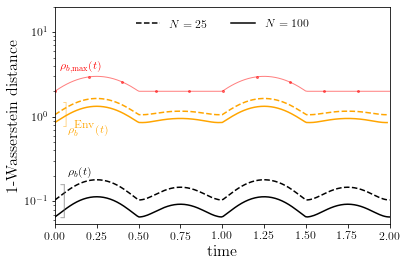

In [67]:
W1bmax = np.zeros(Nt)

for it in range(0,Nt):
    W1bmax[it] = Deltabmax(0.,T[it])
    

plt.figure()
# theoretical max
plt.plot(T,W1bmax,c='red',linewidth=1,marker='o',alpha=.5, markevery=20, markersize=2)
b2, = plt.plot(T,W1b_WAS[0,1,:],c='k',linestyle='dashed')
b4, = plt.plot(T,W1b_WAS[1,1,:],c='k',linestyle='-')

plt.plot(np.concatenate((T[0:NtE],T[0:NtE]+1.)),np.concatenate((W1b_envelope[0,1,:],W1b_envelope[0,1,:])),c='orange',linestyle='dashed')
plt.plot(np.concatenate((T[0:NtE],T[0:NtE]+1.)),np.concatenate((W1b_envelope[1,1,:],W1b_envelope[1,1,:])),c='orange',linestyle='-')


plt.yscale(value="log")
plt.xlim(0., right=tend) 
plt.ylim(0.,20.)
plt.ylabel('1-Wasserstein distance',fontsize=16) 
plt.xlabel('time',fontsize=16)

plt.text(.03,3.5,r'$\rho_{b,\max}(t)$',fontsize=12,color='r')
plt.text(.05,.9,r']',color='orange',fontsize=25,alpha=.5)
plt.text(.08,.6,r'$\rho_{b}^{\textnormal{Env}}(t)$',fontsize=12,color='orange')
plt.text(.03,.08,r']',color='dimgray',fontsize=35, alpha=.5)
plt.text(.08,.2,r'$\rho_{b}(t)$',fontsize=12,color='k')
leg = plt.legend([b2, b4],[
                             r'$N='+str(Nvalues[0])+r'$',
                             r'$N='+str(Nvalues[1])+r'$'],frameon=False,facecolor='white',ncol=2, loc="upper center", fontsize=12)
    
plt.savefig('Figure3.pdf', dpi=800, bbox_inches=None, pad_inches=0.,
        frameon=None) 

# Propagation of the upper and lower CDFs


In [68]:
# useful functions:
def heaviside(x):
    if (x>=0.):
        h = 1.
    else:
        h = 0.
    return h

def r(y,k,alpha):
    return - k*alpha*y^alpha 

def analyticalu(x,t,a1,a2,a3):  
    
    xstar = x - t
    tstar = t - x
    usol = (a1+a2)*np.exp(-k*(x-xstar))*heaviside(xstar)+ (a1 + a2*(1.+a3*np.sin(2.*np.pi*tstar)))*np.exp(-k*x)*heaviside(tstar)
    return usol

ustar = np.zeros((Nx,Nt))
Fenvelope = np.zeros((Nx,Nt,NU,4)) 
for ix in range(0,Nx):
    for it in range(0,Nt):
        ustar[ix,it] = analyticalu(X[ix],T[it],astar[0],astar[1],astar[2])

In [69]:
def analyticalCDF_alpha1(x,t,Nval,a,nn,ir): # obeying the exact CDF equation, with uncertain initial conds in this case
    
    foot1 = x-t
    ecdf = np.arange(1,Nval+1)/Nval 

    if foot1>0.: # initial condition
        UU = u0envelope[nn,ir,:,0]*np.exp(k*t) # shrinked U range. 

        u0sample = np.sort(a[0:Nval,0]+a[0:Nval,1]) 

        timeofflight = t
        yaxis = u0sample*np.exp(k*timeofflight)  
        
        U = UU**np.exp(-k*timeofflight) 
        
        LE = u0envelope[nn,ir,:,1] 
        UE = u0envelope[nn,ir,:,2] 
        
    else: # boundary condition

        UU = ubenvelope[nn,ir,:,0,0]*np.exp(k*x) 
        
        timeofflight = x 
        timefromorigin = t-x
        ubsample = np.sort(a[0:Nval,0] + a[0:Nval,1]*(1.+a[0:Nval,2]*np.sin(2.*np.pi*timefromorigin)))
        yaxis = ubsample*np.exp(k*timeofflight) 
        
        U = UU**np.exp(-k*timeofflight)
                
        LE = np.zeros(NU) 
        UE = np.zeros(NU)
        for iu in range(0,NU):
            interpolator1dL_time = sp.interpolate.interp1d(np.concatenate((T[0:NtE],T[0:NtE]+1.,T[0:1]+tend)),np.concatenate((ubenvelope[nn,ir,iu,1,:],ubenvelope[nn,ir,iu,1,:],ubenvelope[nn,ir,iu,1,0:1])))
            interpolator1dU_time = sp.interpolate.interp1d(np.concatenate((T[0:NtE],T[0:NtE]+1.,T[0:1]+tend)),np.concatenate((ubenvelope[nn,ir,iu,2,:],ubenvelope[nn,ir,iu,2,:],ubenvelope[nn,ir,iu,2,0:1])))

            LE[iu] = interpolator1dL_time(timefromorigin)
            UE[iu] = interpolator1dU_time(timefromorigin) 
              
    return yaxis,ecdf,UU,LE,UE 

In [70]:
ib=1

for it in range(0,NtE):  
    ubsample = a[:,0] + a[:,1]*(1+a[:,2]*np.sin(2.*np.pi*tstar[it]))
    
    for nn in range(0,NNs):
        t,c = tcconstruction(ubsample,Ubmin,Ubmax(0.,T[it]),Nvalues[nn])
        b = bconstruction(t)
        tr = treflF(t,Ubmin,Ubmax(0.,T[it]))
        br = bconstruction(tr)
#         for ib in range(0,Nbetas):
        rhobi = rhob(xstar,tstar[it],Nvalues[nn],epsilonNref[ib],Nref[ib])
        print('nn,ib,it:',nn,ib,it,rhobi)
        print(b[Nvalues[nn],0],rhobi) # b[Nval,0] needs to be larger than rho
        rhoBC[nn,ib,it] = rhobi
        js,iss,y,tau,kmax = indexing(b,t,rhobi)
        jsr,issr,yr,taur,kmaxr = indexing(br,tr,rhobi)
                
        for iu in range(0,NU):
                uub,leb,ueb,ubsample = envelopeub(tstar[it],Ub[iu],Nvalues[nn],rhobi,a)
                ubenvelope[nn,ib,iu,:,it] = uub,leb,ueb

        W1b_envelope[nn,ib,it] = np.trapz(ubenvelope[nn,ib,:,2,it]-ubenvelope[nn,ib,:,1,it],x=ubenvelope[nn,ib,:,0,it]) #np.sum(ubenvelope[nn,ib,:,2,it]-ubenvelope[nn,ib,:,1,it])*dUb

nn,ib,it: 0 1 0 0.10420014619173827
0.9046939170931159 0.10420014619173827
nn,ib,it: 1 1 0 0.06564197879454708
0.9372001343695749 0.06564197879454708
nn,ib,it: 0 1 1 0.10763869816025337
0.9210537676698982 0.10763869816025337
nn,ib,it: 1 1 1 0.06780813079769189
0.9525072180997509 0.06780813079769189
nn,ib,it: 0 1 2 0.11134435584127592
0.9373484030833313 0.11134435584127592
nn,ib,it: 1 1 2 0.07014254885570437
0.9677532833040434 0.07014254885570437
nn,ib,it: 0 1 3 0.11527065289665668
0.9535128681368382 0.11527065289665668
nn,ib,it: 1 1 3 0.0726159610098116
0.9828775546943143 0.0726159610098116
nn,ib,it: 0 1 4 0.11937032726152688
0.9694827265310797 0.11937032726152688
nn,ib,it: 1 1 4 0.07519859402481878
0.997819742488293 0.07519859402481878
nn,ib,it: 0 1 5 0.12359646127582061
0.9851943177259455 0.12359646127582061
nn,ib,it: 1 1 5 0.07786089162696147
1.0125202827423356 0.07786089162696147
nn,ib,it: 0 1 6 0.127903309343411
1.0005850107101417 0.127903309343411
nn,ib,it: 1 1 6 0.08057403589648

nn,ib,it: 1 1 54 0.06791054076311029
0.8728804293681525 0.06791054076311029
nn,ib,it: 0 1 55 0.10958074167014836
0.8203133386900009 0.10958074167014836
nn,ib,it: 1 1 55 0.06903154154665611
0.8580722067552998 0.06903154154665611
nn,ib,it: 0 1 56 0.11163744847854494
0.8050125118654783 0.11163744847854494
nn,ib,it: 1 1 56 0.07032718564733659
0.8434624275492121 0.07032718564733659
nn,ib,it: 0 1 57 0.11392457083587425
0.7901090443624389 0.11392457083587425
nn,ib,it: 1 1 57 0.07176798244817877
0.8292320613002764 0.07176798244817877
nn,ib,it: 0 1 58 0.11639323447752845
0.7756623457740883 0.11639323447752845
nn,ib,it: 1 1 58 0.0733231430917939
0.8154378344226524 0.0733231430917939
nn,ib,it: 0 1 59 0.1189940941892304
0.761730004878751 0.1189940941892304
nn,ib,it: 1 1 59 0.07496158204109231
0.8021347347510327 0.07496158204109231
nn,ib,it: 0 1 60 0.12167860963403972
0.7483675600741071 0.12167860963403972
nn,ib,it: 1 1 60 0.07665272079993388
0.7893757923429991 0.07665272079993388
nn,ib,it: 0 1 61 

In [71]:

W1val_BANDics10 = np.zeros((Nt))
W1val_BANDics50 = np.zeros((Nt))

u0env_ics = np.zeros((NU,3))
ubenv_ics = np.zeros((NU,3))

nn=1
ib=1
ics = 10
for it in range(0,Nt):
    print(it)
    if X[ics]>=T[it]:
        rhozero = rho0(X[ics],Nvalues[nn],epsilonNref[ib],Nref[ib])
        for iu in range(0,NU):
                uu,le,ue,u0sample = envelopeu0(.1,U0[iu],Nvalues[nn],rhozero,0.,1.,a)
                u0env_ics[iu,:] = uu,le,ue
        W10val =  np.trapz(u0env_ics[:,2]-u0env_ics[:,1],x=u0env_ics[:,0])
        W1val_BANDics10[it] = W10val*np.exp(k*T[it])
    else:
        timefromorigin = T[it]-X[ics]
        ubsample = a[:,0] + a[:,1]*(1.+a[:,2]*np.sin(2.*np.pi*timefromorigin))
        t,c = tcconstruction(ubsample,Ubmin,Ubmax(0.,T[it]),Nvalues[nn])
        b = bconstruction(t)
        tr = treflF(t,Ubmin,Ubmax(0.,T[it]))
        br = bconstruction(tr)
        rhobi = rhob(X[ics],timefromorigin,Nvalues[nn],epsilonNref[ib],Nref[ib])
        js,iss,y,tau,kmax = indexing(b,t,rhobi)
        jsr,issr,yr,taur,kmaxr = indexing(br,tr,rhobi)
        Ub = np.linspace(0.,Ubmax(0.,T[it]),NU)
        for iu in range(0,NU):
                uub,leb,ueb,ubsample = envelopeub(timefromorigin,Ub[iu],Nvalues[nn],rhobi,a)
                ubenv_ics[iu,:] = uub,leb,ueb
        
        W1bval =  np.trapz(ubenv_ics[:,2]-ubenv_ics[:,1],x=ubenv_ics[:,0]) 
        
        W1val_BANDics10[it] = W1bval*np.exp(k*X[ics])
        


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [72]:
ics = 50
for it in range(0,Nt):
    print(it)
    if X[ics]>=T[it]:
        rhozero = rho0(X[ics],Nvalues[nn],epsilonNref[ib],Nref[ib])
        for iu in range(0,NU):
                uu,le,ue,u0sample = envelopeu0(.1,U0[iu],Nvalues[nn],rhozero,0.,1.,a)
                u0env_ics[iu,:] = uu,le,ue
        W10val =  np.trapz(u0env_ics[:,2]-u0env_ics[:,1],x=u0env_ics[:,0])
        W1val_BANDics50[it] = W10val*np.exp(k*T[it])
    else:
        timefromorigin = T[it]-X[ics]
        ubsample = a[:,0] + a[:,1]*(1.+np.sin(2.*np.pi*timefromorigin)*a[:,2])
        t,c = tcconstruction(ubsample,Ubmin,Ubmax(0.,T[it]),Nvalues[nn])
        b = bconstruction(t)
        tr = treflF(t,Ubmin,Ubmax(0.,T[it]))
        br = bconstruction(tr)
        rhobi = rhob(X[ics],timefromorigin,Nvalues[nn],epsilonNref[ib],Nref[ib])
        js,iss,y,tau,kmax = indexing(b,t,rhobi)
        jsr,issr,yr,taur,kmaxr = indexing(br,tr,rhobi)
        Ub = np.linspace(0.,Ubmax(0.,T[it]),NU)
        for iu in range(0,NU):
                uub,leb,ueb,ubsample = envelopeub(timefromorigin,Ub[iu],Nvalues[nn],rhobi,a)
                ubenv_ics[iu,:] = uub,leb,ueb
        
        W1bval =  np.trapz(ubenv_ics[:,2]-ubenv_ics[:,1],x=ubenv_ics[:,0]) 
        
        W1val_BANDics50[it] = W1bval*np.exp(k*X[ics])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [74]:
W1val_BAND = np.zeros((NNs,Nbetas,Nx,Nt))
W1val_BAND2 = np.zeros((NNs,Nbetas,Nx,Nt))

for nn in range(0,NNs):
    for ib in range(0,Nbetas):
        for ix in range(0,Nx): #  
            for it in range(0,Nt): # 
                
                Y,E,U,LE,UE = analyticalCDF_alpha1(X[ix],T[it],Nvalues[nn],a,nn,ib)
                
                W1val_BAND[nn,ib,ix,it] = np.trapz(UE-LE,x=U) 
          
                if X[ix]>=T[it]: # IC
                    W1val_BAND2[nn,ib,ix,it] =  W10_envelope[nn,ib]*np.exp(k*T[it])
                else:

                    timefromorigin = T[it]-X[ix]
                    
                    interpolator = sp.interpolate.interp1d(np.concatenate((T[0:NtE],T[0:NtE]+1.,T[0:1]+tend)),np.concatenate((W1b_envelope[nn,ib,:],W1b_envelope[nn,ib,:],W1b_envelope[nn,ib,0:1])))
                    W1val_BAND2[nn,ib,ix,it] = interpolator(timefromorigin)*np.exp(k*X[ix]) 


In [76]:
W1theoreticalmax = np.zeros((NNs,Nbetas,Nx,Nt))

for nn in range(0,NNs):
    for ib in range(0,Nbetas):
        for ix in range(0,Nx): 
            for it in range(0,Nt): 
                
                if X[ix]>=T[it]: # IC
                    W1theoreticalmax[nn,ib,ix,it] =  2.*np.exp(k*T[it])
                else:

                    W1theoreticalmax[nn,ib,ix,it] = (Ubmax(0.,T[it]))*np.exp(k*X[ix]) 

In [77]:
XmgE, TmgE = np.meshgrid(X, T[0:NtE])

/Users/francesca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


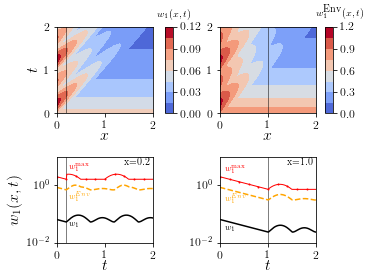

In [80]:
fig,axes = plt.subplots(2, 2) #sharex='all', , sharey='all'
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
theoreticalmax2 = np.amax(W1val_BAND[1,1,:,:])
theoreticalmax = np.amax(W1_WAS[1,1,:,:])

pcf = axes[0,0].contourf(Xmg,Tmg,np.transpose(W1_WAS[1,1,:,:]),cmap='coolwarm',vmin=0.,vmax=theoreticalmax)
pcf2 = axes[0,1].contourf(Xmg,Tmg,np.transpose(W1val_BAND[1,1,:,:]),cmap='coolwarm',vmin=0.,vmax=theoreticalmax2)

ixs = 10
b1, = axes[1,0].plot(T,W1_WAS[1,1,ixs,:],c='k')
axes[0,0].plot([X[ixs],X[ixs]],[0.,tend],c='k',linewidth=.5)
axes[1,0].plot([X[ixs],X[ixs]],[0.,10.],c='k',linewidth=.5)
b2, = axes[1,0].plot(T[0:Nt],W1val_BANDics10[0:Nt],c='orange',linestyle='dashed') 
b3, = axes[1,0].plot(T,W1theoreticalmax[nn,ib,ixs,:],c='red', linewidth = 1., marker = 'o', markevery=20, markersize = 1) 

ixs = 50
axes[1,1].plot(T,W1_WAS[1,1,ixs,:],c='k')
axes[0,1].plot([X[ixs],X[ixs]],[0.,tend],c='k',linewidth=.5)
axes[1,1].plot([X[ixs],X[ixs]],[0.,10.],c='k',linewidth=.5)
axes[1,1].plot(T[0:Nt],W1val_BANDics50[0:Nt],c='orange',linestyle='dashed')
axes[1,1].plot(T,W1theoreticalmax[nn,ib,ixs,:],c='red', linewidth = 1., marker = 'o', markevery=20, markersize = 1) 
axes[1,1].set_yscale(value="log")
axes[1,0].set_yscale(value="log")

axes[0,0].set_xlim(left=0., right=xend)
axes[0,1].set_xlim(left=0., right=xend)
axes[0, 0].set_ylabel(r"$t$",fontsize=16)
axes[0, 0].set_xlabel(r"$x$",fontsize=16,labelpad=-2)
axes[0, 1].set_xlabel(r"$x$",fontsize=16,labelpad=-2)

axes[1,0].set_xlim(left=0., right=tend)
axes[1,1].set_xlim(left=0., right=tend)

axes[1,0].set_ylim(bottom=0.01, top=10.)
axes[1,1].set_ylim(bottom=0.01, top=10.)
axes[1, 0].set_ylabel(r"$w_1(x,t)$",fontsize=16)
axes[1, 0].set_xlabel(r"$t$",fontsize=16,labelpad=-2)
axes[1, 1].set_xlabel(r"$t$",fontsize=16,labelpad=-2)

axes[0,0].text(2.1,2.2,r'$w_1(x,t)$',fontsize=9.9)
axes[0,1].text(2.,2.2,r"$w_1^{\textnormal{Env}}(x,t)$",fontsize=9.9)
axes[1,0].text(1.41,5.,'x='+str(np.around(X[10],decimals=1)),fontsize=10)
axes[1,1].text(1.4,5.,'x='+str(np.round(X[55],decimals=0)),fontsize=10)

axes[1,1].text(.1,2.5,r'$w_1^{\max}$',fontsize=8,color='red')
axes[1,1].text(.1,.23,r'$w_1^{\small{Env}}$',fontsize=8,color='orange')
axes[1,1].text(.1,.025,r'$w_1$',fontsize=8,color='k')

axes[1,0].text(.25,3.,r'$w_1^{\max}$',fontsize=8,color='red')
axes[1,0].text(.25,.28,r'$w_1^{Env}$',fontsize=8,color='orange')
axes[1,0].text(.25,.035,r'$w_1$',fontsize=8,color='k')

fig.subplots_adjust(bottom=0.15, top=0.9, left=0.2, right=0.8,
                    wspace=.7, hspace=0.5)

cb_ax = fig.add_axes([.45, 0.60, 0.02, 0.30])
cbar = fig.colorbar(pcf, cax=cb_ax, ticks = [0.,.03,.06,.09,.12])

cb_ax = fig.add_axes([.82, 0.60, 0.02, 0.30])
cbar = fig.colorbar(pcf2, cax=cb_ax, ticks = [0.,.3,.6,.9,1.2])

plt.savefig('Figure7_alt.pdf', dpi=800, bbox_inches=None, pad_inches=0.,
        frameon=None)

/Users/francesca/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


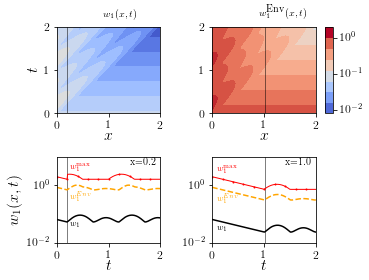

In [81]:
fig,axes = plt.subplots(2, 2) #sharex='all', , sharey='all'
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
theoreticalmax2 = np.amax(W1val_BAND[1,1,:,:])
theoreticalmax = np.amax(W1_WAS[1,1,:,:])

values = Xmg*0.-2.1
values[100,0] = 0.15


pcfminmax = axes[0,0].contourf(Xmg,Tmg,values,cmap='coolwarm',vmin=-2.1,vmax=0.15)

pcf = axes[0,0].contourf(Xmg,Tmg,np.transpose(np.log10(W1_WAS[1,1,:,:])),cmap='coolwarm',vmin=-2.1,vmax=0.15)
pcf2 = axes[0,1].contourf(Xmg,Tmg,np.transpose(np.log10(W1val_BAND[1,1,:,:])),cmap='coolwarm',vmin=-2.1,vmax=.15)

ixs = 10
b1, = axes[1,0].plot(T,W1_WAS[1,1,ixs,:],c='k')
axes[0,0].plot([X[ixs],X[ixs]],[0.,tend],c='k',linewidth=.5)
axes[1,0].plot([X[ixs],X[ixs]],[0.,10.],c='k',linewidth=.5)
b2, = axes[1,0].plot(T[0:Nt],W1val_BANDics10[0:Nt],c='orange',linestyle='dashed') 
b3, = axes[1,0].plot(T,W1theoreticalmax[nn,ib,ixs,:],c='red', linewidth = 1., marker = 'o', markevery=20, markersize = 1) 

ixs = 50
axes[1,1].plot(T,W1_WAS[1,1,ixs,:],c='k')
axes[0,1].plot([X[ixs],X[ixs]],[0.,tend],c='k',linewidth=.5)
axes[1,1].plot([X[ixs],X[ixs]],[0.,10.],c='k',linewidth=.5)
axes[1,1].plot(T[0:Nt],W1val_BANDics50[0:Nt],c='orange',linestyle='dashed')
axes[1,1].plot(T,W1theoreticalmax[nn,ib,ixs,:],c='red', linewidth = 1., marker = 'o', markevery=20, markersize = 1) 
axes[1,1].set_yscale(value="log")
axes[1,0].set_yscale(value="log")

axes[0,0].set_xlim(left=0., right=xend)
axes[0,1].set_xlim(left=0., right=xend)
axes[0, 0].set_ylabel(r"$t$",fontsize=16)
axes[0, 0].set_xlabel(r"$x$",fontsize=16,labelpad=-2)
axes[0, 1].set_xlabel(r"$x$",fontsize=16,labelpad=-2)

axes[1,0].set_xlim(left=0., right=tend)
axes[1,1].set_xlim(left=0., right=tend)

axes[1,0].set_ylim(bottom=0.01, top=10.)
axes[1,1].set_ylim(bottom=0.01, top=10.)
axes[1, 0].set_ylabel(r"$w_1(x,t)$",fontsize=16)
axes[1, 0].set_xlabel(r"$t$",fontsize=16,labelpad=-2)
axes[1, 1].set_xlabel(r"$t$",fontsize=16,labelpad=-2)

axes[0,0].text(.9,2.2,r'$w_1(x,t)$',fontsize=9.9)
axes[0,1].text(.9,2.2,r"$w_1^{\textnormal{Env}}(x,t)$",fontsize=9.9)
axes[1,0].text(1.41,5.,'x='+str(np.around(X[10],decimals=1)),fontsize=10)
axes[1,1].text(1.4,5.,'x='+str(np.round(X[55],decimals=0)),fontsize=10)

axes[1,1].text(.1,2.5,r'$w_1^{\max}$',fontsize=8,color='red')
axes[1,1].text(.1,.23,r'$w_1^{\small{Env}}$',fontsize=8,color='orange')
axes[1,1].text(.1,.025,r'$w_1$',fontsize=8,color='k')

axes[1,0].text(.25,3.,r'$w_1^{\max}$',fontsize=8,color='red')
axes[1,0].text(.25,.28,r'$w_1^{Env}$',fontsize=8,color='orange')
axes[1,0].text(.25,.035,r'$w_1$',fontsize=8,color='k')

fig.subplots_adjust(bottom=0.15, top=0.9, left=0.2, right=0.8,
                    wspace=.5, hspace=0.5)

cb_ax = fig.add_axes([.82, 0.60, 0.02, 0.30])
cbar = fig.colorbar(pcfminmax, cax=cb_ax, ticks=[-2.,-1.,0.])
cb_ax.set_yticklabels([r'$10^{-2}$',r'$10^{-1}$', r'$10^0$'])

plt.savefig('Figure7.pdf', dpi=800, bbox_inches=None, pad_inches=0.,
        frameon=None)